In [1]:
from __future__ import print_function

import sys

import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import sklearn


import random
import sklearn.datasets
import time

In [2]:
mnist = sklearn.datasets.fetch_mldata('MNIST original')
X, Y = mnist['data'], np.array(mnist['target'], dtype='int')

ntrain = 60000

X_train, Y_train = X[:ntrain], Y[:ntrain]
X_test, Y_test = X[ntrain:], Y[ntrain:]

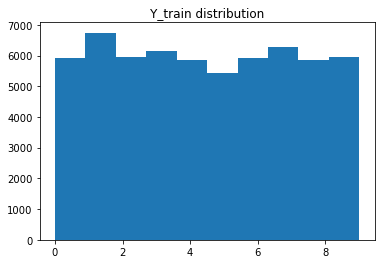

In [3]:
plt.hist(Y_train)
plt.title('Y_train distribution')
plt.show()

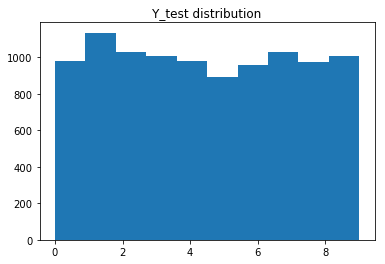

In [4]:
plt.hist(Y_test)
plt.title('Y_test distribution')
plt.show()

In [9]:
permutation = np.random.permutation(ntrain)
n_dev = 20000

X_dev, Y_dev = X_train[permutation][:n_dev], Y_train[permutation][:n_dev]

permutation = np.random.permutation(n_dev)
n_dev_train = n_dev // 100 * 90

X_dev_train, Y_dev_train = X_dev[permutation][:n_dev_train], Y_dev[permutation][:n_dev_train]
X_dev_test, Y_dev_test = X_dev[permutation][n_dev_train:], Y_dev[permutation][n_dev_train:]

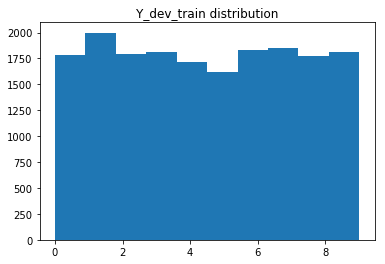

In [10]:
plt.hist(Y_dev_train)
plt.title('Y_dev_train distribution')
plt.show()

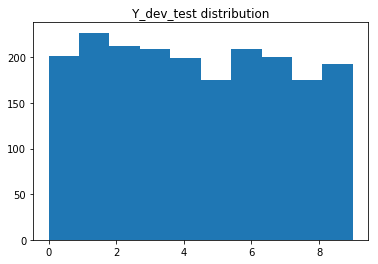

In [11]:
plt.hist(Y_dev_test)
plt.title('Y_dev_test distribution')
plt.show()

<b>SVM, Polynomial, 98.1%</b>

На данный момент это лучшее решение, которое я нашел.

Точность на тестовой выборке 98.1%

In [10]:
from sklearn.svm import SVC

print(X_train.shape, X_test.shape)
classifier = SVC(kernel="poly", 
                 degree=2, 
                 coef0=0,
                 C=1,
                 gamma=3,
                 decision_function_shape="ovr"
                )

start = time.time()
classifier.fit(X_train, Y_train)
end = time.time()
print ("Time", end - start)

print("Train score {:.3f}".format(classifier.score(X_train, Y_train)))
print("Test score {:.3f}".format(classifier.score(X_test, Y_test)))

(60000, 784) (10000, 784)
Time 201.5941231250763
Train score 1.000
Test score 0.981


In [ ]:
from sklearn.svm import SVC

print(X_train.shape, X_test.shape)
classifier = SVC(C=3,
                 gamma=0.01,
                 kernel="rbf"
                )

start = time.time()
classifier.fit(X_train, Y_train)
end = time.time()
print ("Time", end - start)

print("Train score {:.4f}".format(classifier.score(X_train, Y_train)))
print("Test score {:.4f}".format(classifier.score(X_test, Y_test)))

(60000, 784) (10000, 784)


<b>3NN + RandomForest, 97.6%</b>

Вторая лучшая точность на тесте. 97.6% при использовании:

1) KNeighborsClassifier(n_neighbors=3, n_jobs=-1)

2) RandomForestClassifier(n_estimators=200, n_jobs=-1)

3) ExtraTreesClassifier(n_estimators=45, max_depth=195, n_jobs=-1)


Время работы на тесте около 2 минут, тренировка 30 секунд. voting ==soft

Третья лучшая точность на тесте. 97.5% при использовании:

1) KNeighborsClassifier(n_neighbors=3, n_jobs=-1)

2) RandomForestClassifier(n_estimators=200, n_jobs=-1)

Время работы на тесте около 2 минут, тренировка 25 секунд. voting ==soft

In [120]:
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

knn_classifier = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
rt_classifier = RandomForestClassifier(n_estimators=200, n_jobs=-1)
et_classifier = ExtraTreesClassifier(n_estimators=45,
                                     max_depth=195,
                                     n_jobs=-1)

eclf1 = VotingClassifier(estimators=[("rt", rt_classifier), ("et", et_classifier), ("knn", knn_classifier)], 
                         voting='soft', 
                         n_jobs=-1)
                                     
start = time.time()
eclf1.fit(X_train, Y_train)
end = time.time()
print ("Time", end - start)
start = time.time()
print("Test score {:.3f}".format(eclf1.score(X_test, Y_test)))
end = time.time()
print ("Time", end - start)

C:\Users\vladislav.ermolin\Anaconda3\lib\site-packages\sklearn\externals\joblib\pool.py:438: UserWarning: Failed to clean temporary folder: C:\Users\VLADIS~1.ERM\AppData\Local\Temp\joblib_memmaping_pool_3028_2549125236104
  warnings.warn("Failed to clean temporary folder: %s" % folder_path)


Time 29.216692686080933
Test score 0.976
Time 121.42188572883606


<b>Random forest, 97.2%</b>

Третий лучший результат. 97.2% на тесте, например при n_estimators == 200.

Необходимо запустить GridSearch по n_estimators, max_features и min_samples_split

In [13]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=200,
                             n_jobs=-1)

start = time.time()
clf.fit(X_train, Y_train)
end = time.time()
print ("Time", end - start)
start = time.time()
print("Train score {:.3f}".format(clf.score(X_train, Y_train)))
end = time.time()
print ("Time", end - start)
start = time.time()
print("Test score {:.3f}".format(clf.score(X_test, Y_test)))
end = time.time()
print ("Time", end - start)

Time 19.98013186454773
Train score 0.999
Time 0.9324784278869629
Test score 0.971
Time 0.23662948608398438


In [ ]:
from sklearn.ensemble import RandomForestClassifier
import sklearn.model_selection

tuned_parameters = [
    {
        'n_estimators': range(5, 50, 5), 
        'max_depth': [None] + list(range(5, 30, 5)),
        'max_features' : ["auto"] + list(range(10, 60, 5)),
        'min_samples_split' : list(range(2, 5))
    }
]

grid_search = sklearn.model_selection.GridSearchCV(
    RandomForestClassifier(),
    tuned_parameters,
    cv=5,
    n_jobs=-1
)
grid_search.fit(X_train, Y_train)

means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

print(grid_search.best_params_)

<b>Decision tree, 88.4%</b>

Лучшая точность на тесте 88.4%, при max_depth = 15

In [82]:
from sklearn.tree import DecisionTreeClassifier

dectree_classifier = DecisionTreeClassifier(max_depth=15)

start = time.time()
dectree_classifier.fit(X_train, Y_train)
end = time.time()
print ("Time", end - start)
start = time.time()
print("Train score {:.3f}".format(dectree_classifier.score(X_train, Y_train)))
end = time.time()
print ("Time", end - start)
start = time.time()
print("Test score {:.3f}".format(dectree_classifier.score(X_test, Y_test)))
end = time.time()
print ("Time", end - start)

Time 9.100199222564697
Train score 0.984
Time 0.09324765205383301
Test score 0.884
Time 0.01704549789428711


In [81]:
from sklearn.tree import DecisionTreeClassifier
import sklearn.model_selection

tuned_parameters = [
    {
        'splitter': ['best'], 
        'max_depth': [None] + list(range(5, 200, 5))
    }
]

grid_search = sklearn.model_selection.GridSearchCV(
    DecisionTreeClassifier(),
    tuned_parameters,
    cv=5,
    n_jobs=-1
)
grid_search.fit(X_train, Y_train)

means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

print(grid_search.best_params_)

0.867 (+/-0.013) for {'max_depth': None, 'splitter': 'best'}
0.669 (+/-0.029) for {'max_depth': 5, 'splitter': 'best'}
0.849 (+/-0.014) for {'max_depth': 10, 'splitter': 'best'}
0.871 (+/-0.013) for {'max_depth': 15, 'splitter': 'best'}
0.870 (+/-0.015) for {'max_depth': 20, 'splitter': 'best'}
0.869 (+/-0.016) for {'max_depth': 25, 'splitter': 'best'}
0.868 (+/-0.014) for {'max_depth': 30, 'splitter': 'best'}
0.868 (+/-0.013) for {'max_depth': 35, 'splitter': 'best'}
0.867 (+/-0.015) for {'max_depth': 40, 'splitter': 'best'}
0.867 (+/-0.014) for {'max_depth': 45, 'splitter': 'best'}
0.867 (+/-0.012) for {'max_depth': 50, 'splitter': 'best'}
0.867 (+/-0.013) for {'max_depth': 55, 'splitter': 'best'}
0.866 (+/-0.016) for {'max_depth': 60, 'splitter': 'best'}
0.867 (+/-0.016) for {'max_depth': 65, 'splitter': 'best'}
0.866 (+/-0.015) for {'max_depth': 70, 'splitter': 'best'}
0.868 (+/-0.015) for {'max_depth': 75, 'splitter': 'best'}
0.866 (+/-0.015) for {'max_depth': 80, 'splitter': 'bes

<b>Extra tree</b>

In [118]:
from sklearn.ensemble import ExtraTreesClassifier

dectree_classifier = ExtraTreesClassifier(n_estimators=45,
                                          max_depth=240,
                                          n_jobs=-1)

start = time.time()
dectree_classifier.fit(X_train, Y_train)
end = time.time()
print ("Time", end - start)
start = time.time()
print("Train score {:.3f}".format(dectree_classifier.score(X_train, Y_train)))
end = time.time()
print ("Time", end - start)
start = time.time()
print("Test score {:.3f}".format(dectree_classifier.score(X_test, Y_test)))
end = time.time()
print ("Time", end - start)

Time 6.922408580780029
Train score 1.000
Time 0.5985908508300781
Test score 0.972
Time 0.14438533782958984


Best params in range:

1) 'n_estimators': range(5, 50, 5)

2) 'max_depth': [None] + list(range(5, 200, 5))

were {'max_depth': 195, 'n_estimators': 45}

In [103]:
from sklearn.ensemble import ExtraTreesClassifier
import sklearn.model_selection

tuned_parameters = [
    {
        'n_estimators': range(40, 70, 5), 
        'max_depth': [None] + list(range(180, 250, 5))
    }
]

grid_search = sklearn.model_selection.GridSearchCV(
    ExtraTreesClassifier(),
    tuned_parameters,
    cv=5,
    n_jobs=-1
)
grid_search.fit(X_train, Y_train)

means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

print(grid_search.best_params_)

0.919 (+/-0.011) for {'max_depth': None, 'n_estimators': 5}
0.946 (+/-0.009) for {'max_depth': None, 'n_estimators': 10}
0.955 (+/-0.006) for {'max_depth': None, 'n_estimators': 15}
0.960 (+/-0.005) for {'max_depth': None, 'n_estimators': 20}
0.962 (+/-0.005) for {'max_depth': None, 'n_estimators': 25}
0.964 (+/-0.004) for {'max_depth': None, 'n_estimators': 30}
0.965 (+/-0.006) for {'max_depth': None, 'n_estimators': 35}
0.966 (+/-0.005) for {'max_depth': None, 'n_estimators': 40}
0.967 (+/-0.004) for {'max_depth': None, 'n_estimators': 45}
0.723 (+/-0.028) for {'max_depth': 5, 'n_estimators': 5}
0.766 (+/-0.025) for {'max_depth': 5, 'n_estimators': 10}
0.793 (+/-0.019) for {'max_depth': 5, 'n_estimators': 15}
0.803 (+/-0.022) for {'max_depth': 5, 'n_estimators': 20}
0.810 (+/-0.031) for {'max_depth': 5, 'n_estimators': 25}
0.816 (+/-0.024) for {'max_depth': 5, 'n_estimators': 30}
0.821 (+/-0.022) for {'max_depth': 5, 'n_estimators': 35}
0.826 (+/-0.025) for {'max_depth': 5, 'n_estima

In [8]:
from sklearn.svmimport SVC

classifier = SVC( kernel="poly", degree=2, coef0=0,
        C=1,
        gamma=3,
        decision_function_shape="ovr"  # one vs rest
    )

start = time.time()
classifier.fit(X_dev_train, Y_dev_train)
end = time.time()
print ("Time", end - start)

print("Train score {:.3f}".format(classifier.score(X_dev_train, Y_dev_train)))
print("Test score {:.3f}".format(classifier.score(X_dev_test, Y_dev_test)))

Time 167.92270016670227
Train score 1.000
Test score 0.979


In [9]:
from sklearn.ensemble import BaggingClassifier
from sklearn.svm        import SVC

print(X_dev_train.shape, Y_dev_train.shape)

classifier = SVC( kernel="poly", degree=2, coef0=0,
        C=1,
        gamma=3,
        decision_function_shape="ovr"  # one vs rest
    )

n_estimators = 5
bagging_classifier = BaggingClassifier(base_estimator=classifier,
                                       n_jobs=-1, 
                                       max_samples=1.0 / n_estimators, 
                                       n_estimators=n_estimators)
start = time.time()
bagging_classifier.fit(X_dev_train, Y_dev_train)
end = time.time()
print ("Time", end - start)
print("Train score {:.3f}".format(bagging_classifier.score(X_dev_train, Y_dev_train)))
print("Test score {:.3f}".format(bagging_classifier.score(X_dev_test, Y_dev_test)))

(50000, 784) (50000,)
Time 22.416131258010864
Train score 0.974
Test score 0.969


In [11]:
from sklearn.ensemble import BaggingClassifier
from sklearn.svm        import SVC

print(X_train.shape, X_test.shape)

classifier = SVC( kernel="poly", degree=2, coef0=0,
        C=1,
        gamma=4,
        decision_function_shape="ovr"  # one vs rest
    )

n_estimators = 4
bagging_classifier = BaggingClassifier(base_estimator=classifier,
                                       n_jobs=-1, 
                                       max_samples=1.0 / n_estimators, 
                                       n_estimators=n_estimators, 
                                       bootstrap=False)
start = time.time()
bagging_classifier.fit(X_train, Y_train)
end = time.time()
print ("Time", end - start)
start = time.time()
print("Test score {:.3f}".format(bagging_classifier.score(X_test, Y_test)))
end = time.time()
print ("Time", end - start)

60000
Time 37.7459032535553
Train score 0.980
Test score 0.973


In [96]:
from sklearn.ensemble import GradientBoostingClassifier
        
classifier = GradientBoostingClassifier(n_estimators=20)

start = time.time()
classifier.fit(X_train, Y_train)
end = time.time()
print ("Time", end - start)
start = time.time()
print("Test score {:.3f}".format(classifier.score(X_test, Y_test)))
end = time.time()
print ("Time", end - start)

Time 360.5964789390564
Test score 0.886
Time 0.09525322914123535


20 mins, 100 boosting, 10 bagging, 93.5%

37 mins, 200 boosting, 10 bagging, 94.5%

100 mins, 2000 boosting, 10 bagging, 95.1%

Большее значение бэггинга не улучшает результат:(

In [125]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
        
Y_train
print(X_train.shape, Y_train.shape)

boosting_n_estimators = 2000
classifier = GradientBoostingClassifier(n_estimators=boosting_n_estimators)

bagging_n_estimators = 10
bagging_classifier = BaggingClassifier(base_estimator=classifier,
                                       n_jobs=-1, 
                                       max_samples=1.0 / bagging_n_estimators, 
                                       n_estimators=bagging_n_estimators)
start = time.time()
bagging_classifier.fit(X_train, Y_train)
end = time.time()
print ("Time", end - start)
print("Train score {:.3f}".format(bagging_classifier.score(X_train, Y_train)))
print("Test score {:.3f}".format(bagging_classifier.score(X_test, Y_test)))

(60000, 784) (60000,)
Time 5869.59738779068
Train score 0.954
Test score 0.951


In [27]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier

print(X_train.shape, X_test.shape)

from sklearn.tree import DecisionTreeClassifier

dectree_classifier = DecisionTreeClassifier(max_depth=15)

ada_estimators = 50
ada_classifier = AdaBoostClassifier(base_estimator=dectree_classifier,
                                    n_estimators=ada_estimators)

bagging_estimators = 10
bagging_classifier = BaggingClassifier(base_estimator=ada_classifier,
                                       n_jobs=-1, 
                                       max_samples=1.0 / bagging_estimators, 
                                       n_estimators=bagging_estimators)


start = time.time()
bagging_classifier.fit(X_train, Y_train)
end = time.time()
print ("Time", end - start)
start = time.time()
print("Train score {:.3f}".format(bagging_classifier.score(X_train, Y_train)))
end = time.time()
print ("Time", end - start)
start = time.time()
print("Test score {:.3f}".format(bagging_classifier.score(X_test, Y_test)))
end = time.time()
print ("Time", end - start)

(60000, 784) (10000, 784)
Time 107.08776664733887
Train score 0.953
Time 9.097191095352173
Test score 0.948
Time 2.0524582862854004
